# COVID-19 in Australia (from covidlive.com.au)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span><ul class="toc-item"><li><span><a href="#other-useful-information" data-toc-modified-id="other-useful-information-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>other useful information</a></span></li><li><span><a href="#State-populations" data-toc-modified-id="State-populations-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>State populations</a></span></li></ul></li><li><span><a href="#Get-the-data" data-toc-modified-id="Get-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the data</a></span></li><li><span><a href="#Capture-cumulative-and-daily-data-for-selected-columns" data-toc-modified-id="Capture-cumulative-and-daily-data-for-selected-columns-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Capture cumulative and daily data for selected columns</a></span></li><li><span><a href="#Weekly-charts" data-toc-modified-id="Weekly-charts-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Weekly charts</a></span></li><li><span><a href="#Bar-Charts" data-toc-modified-id="Bar-Charts-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bar Charts</a></span></li><li><span><a href="#Active-Cases" data-toc-modified-id="Active-Cases-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Active Cases</a></span><ul class="toc-item"><li><span><a href="#Bar-chart-of-active-cases" data-toc-modified-id="Bar-chart-of-active-cases-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Bar chart of active cases</a></span></li><li><span><a href="#Active-cases---line-plots" data-toc-modified-id="Active-cases---line-plots-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Active cases - line plots</a></span></li></ul></li><li><span><a href="#Source-of-infection" data-toc-modified-id="Source-of-infection-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Source of infection</a></span></li><li><span><a href="#Local-cases---speculative" data-toc-modified-id="Local-cases---speculative-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Local cases - speculative</a></span><ul class="toc-item"><li><span><a href="#Create-dataframe-of-local-tranmission" data-toc-modified-id="Create-dataframe-of-local-tranmission-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Create dataframe of local tranmission</a></span></li><li><span><a href="#Bar-charts-cumulative-local-transmission" data-toc-modified-id="Bar-charts-cumulative-local-transmission-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Bar charts cumulative local transmission</a></span></li><li><span><a href="#Weekly-charts-for-local-transmission" data-toc-modified-id="Weekly-charts-for-local-transmission-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Weekly charts for local transmission</a></span></li><li><span><a href="#Recent-local-transmission-daily-charts" data-toc-modified-id="Recent-local-transmission-daily-charts-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Recent local transmission daily charts</a></span></li><li><span><a href="#Compare-Sydney-and-Melbourne-outbreaks" data-toc-modified-id="Compare-Sydney-and-Melbourne-outbreaks-8.5"><span class="toc-item-num">8.5&nbsp;&nbsp;</span>Compare Sydney and Melbourne outbreaks</a></span></li></ul></li><li><span><a href="#Hospitalised" data-toc-modified-id="Hospitalised-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Hospitalised</a></span></li><li><span><a href="#The-End" data-toc-modified-id="The-End-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Python set-up

In [1]:
# global imports
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.units as munits
import matplotlib.dates as mdates
import datetime

from pathlib import Path
from typing import Dict, List

# local imports
sys.path.append(r'../bin')
import plotstuff as ps

#pandas
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting
plt.style.use('ggplot')
%matplotlib inline

# matplotlib stuff for date formatting xticklabels
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter

### other useful information

In [2]:
# save location
CHART_DIRECTORY = '../charts'
Path(CHART_DIRECTORY).mkdir(parents=True, exist_ok=True)
CHART_DIRECTORY += '/!AS2-'

SOURCE = 'Source: https://covidlive.com.au/'

AU_COLOURS = ['#dd0000', 'darkorange', 'gold', 'seagreen',
              'dodgerblue', 'blue', 'mediumorchid', 'hotpink',
              '#555555']  

warning_count = 0

# used in charts of the recent period
RECENT = 62 # days

### State populations

In [3]:
# Constants across all tests
state_pop = {
    # source: https://www.abs.gov.au/statistics/people/population/national-state-and-territory-population/latest-release
    # population at 30 June 2020
    'NSW':        8_164_100,
    'Victoria':   6_694_900,
    'Queensland': 5_174_400,
    'SA':         1_769_300,
    'WA':         2_661_900,
    'Tasmania':     540_600,
    'ACT':          431_100,
    'NT':           246_000,
}
au_population = sum(state_pop.values())
print(f'Australian population: {au_population:,}')
state_pop['Australia'] = au_population
power = 6
factor = 10 ** power
state_pop = pd.Series(state_pop) / factor

Australian population: 25,682,300


## Get the data

In [4]:
def get_data_from_JSON():
    """ Get the latest data from covidlive.com.au
        Return a tuple containing (0) a dictionary of dataframes, 
        one dataframe for each state, and (1) the complete 
        DataFrame downloaded from covidlive.com.au"""
    
    # get the data
    url = 'https://covidlive.com.au/covid-live.json'
    all_frame = pd.read_json(url)
    
    # issue a warning if records exist ahead of today
    today = str(datetime.datetime.now().date())
    if (all_frame.REPORT_DATE > today).any():
        print(f'Warning: there are records into the future?')
        global warning_count
        warning_count += 1
        all_frame = all_frame[all_frame.REPORT_DATE <= today]

    # convert to times
    all_frame.REPORT_DATE = pd.to_datetime(all_frame.REPORT_DATE)
        
    # return
    return all_frame

# obtain the latest data ...
frame_data = get_data_from_JSON()

In [5]:
# QUck peak at the data columns
frame_data.columns

Index(['REPORT_DATE', 'LAST_UPDATED_DATE', 'CODE', 'NAME', 'CASE_CNT',
       'TEST_CNT', 'DEATH_CNT', 'RECOV_CNT', 'MED_ICU_CNT', 'MED_VENT_CNT',
       'MED_HOSP_CNT', 'SRC_OVERSEAS_CNT', 'SRC_INTERSTATE_CNT',
       'SRC_CONTACT_CNT', 'SRC_UNKNOWN_CNT', 'SRC_INVES_CNT', 'PREV_CASE_CNT',
       'PREV_TEST_CNT', 'PREV_DEATH_CNT', 'PREV_RECOV_CNT', 'PREV_MED_ICU_CNT',
       'PREV_MED_VENT_CNT', 'PREV_MED_HOSP_CNT', 'PREV_SRC_OVERSEAS_CNT',
       'PREV_SRC_INTERSTATE_CNT', 'PREV_SRC_CONTACT_CNT',
       'PREV_SRC_UNKNOWN_CNT', 'PREV_SRC_INVES_CNT', 'PROB_CASE_CNT',
       'PREV_PROB_CASE_CNT', 'ACTIVE_CNT', 'PREV_ACTIVE_CNT', 'NEW_CASE_CNT',
       'PREV_NEW_CASE_CNT', 'VACC_DIST_CNT', 'PREV_VACC_DIST_CNT',
       'VACC_DOSE_CNT', 'PREV_VACC_DOSE_CNT', 'VACC_PEOPLE_CNT',
       'PREV_VACC_PEOPLE_CNT', 'VACC_AGED_CARE_CNT', 'PREV_VACC_AGED_CARE_CNT',
       'VACC_GP_CNT', 'PREV_VACC_GP_CNT'],
      dtype='object')

## Capture cumulative and daily data for selected columns

In [6]:
def get_table(frame_data, column):
    return (frame_data.pivot(index='REPORT_DATE', 
                               columns='NAME', 
                               values=column))

In [7]:
capture_list = ['VACC_DOSE_CNT', 'VACC_PEOPLE_CNT',
                'CASE_CNT', 'TEST_CNT', 'DEATH_CNT']
capture_desc=['vacc doses', 'vacc people', 'cases', 'tests', 'deaths']

cum_u = {}
daily_u = {}
daily_c = {}
cum_c = {}

for item in capture_list:
    
    # cimulative totals uncorrected
    cum_u[item] = (
        get_table(frame_data, item)
        .replace({0: np.nan})
        .ffill()
        .fillna(0)
        .astype(int)
    )
    
    # adjusted caily and cumulative data (for corrections)
    daily_u[item], daily_c[item], cum_c[item] = (
        ps.dataframe_correction(cum_u[item], verbose=False))
    

## Weekly charts

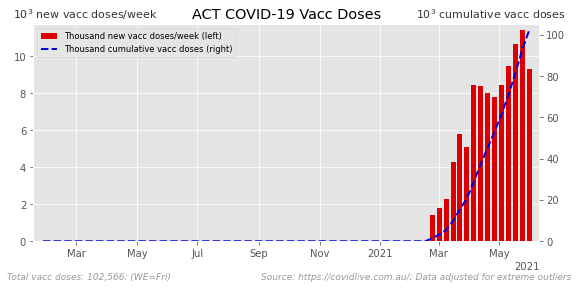

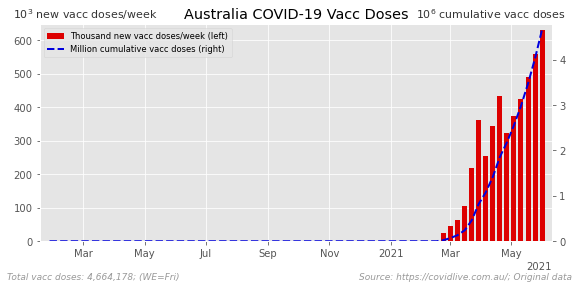

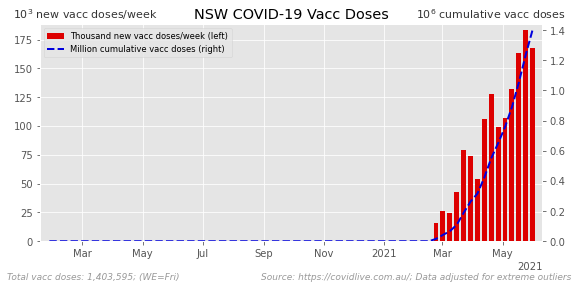

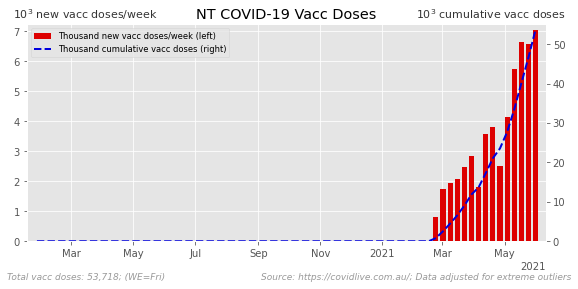

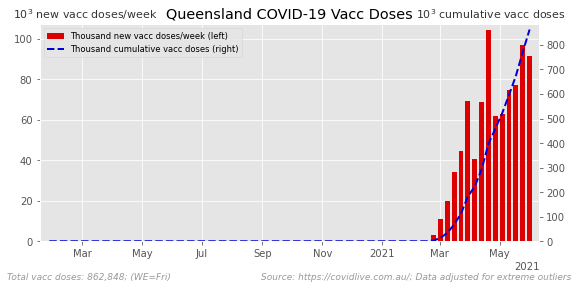

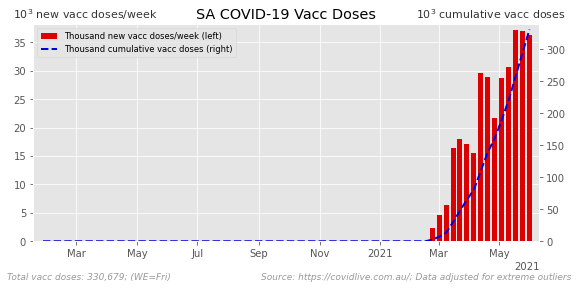

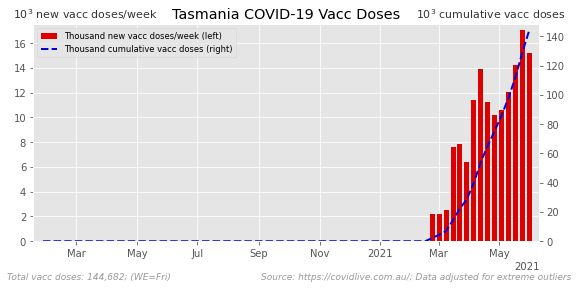

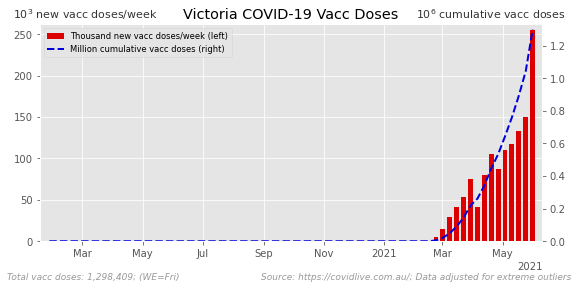

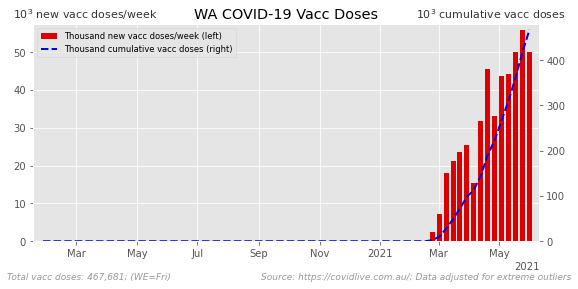

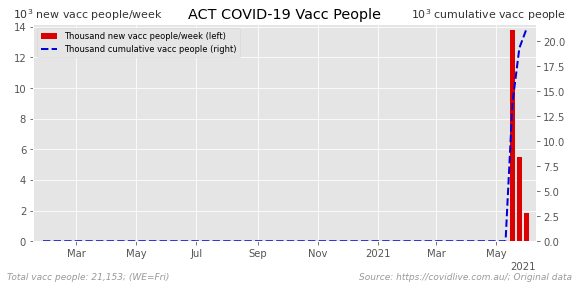

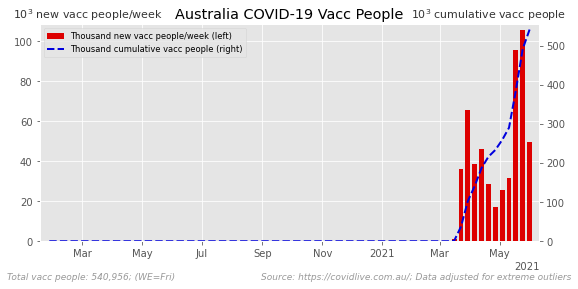

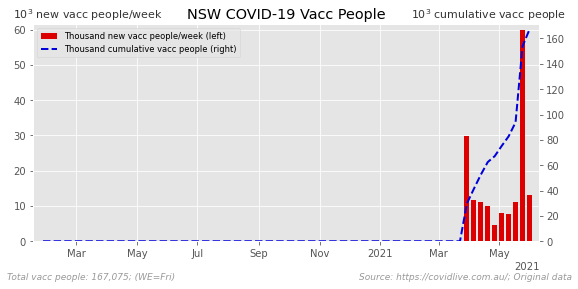

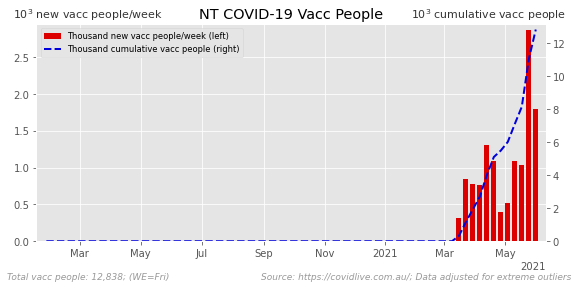

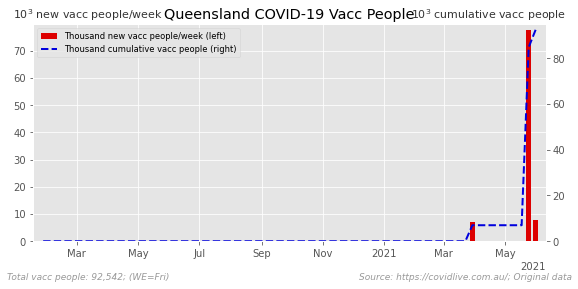

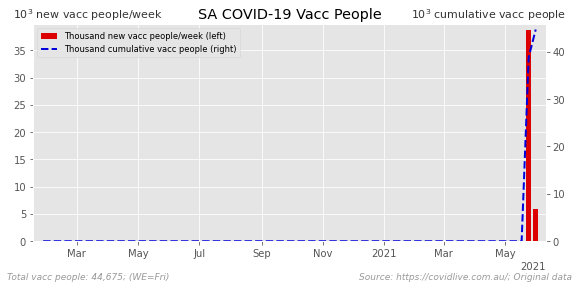

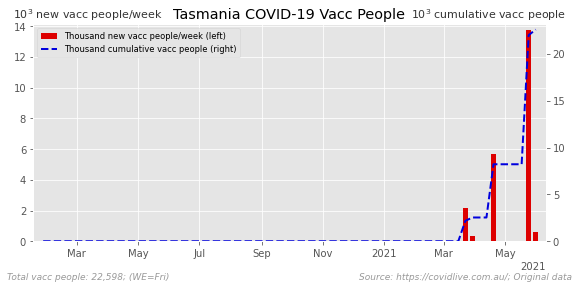

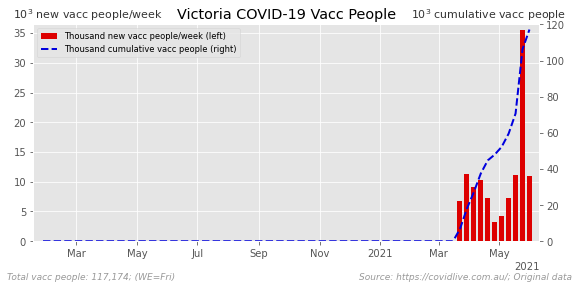

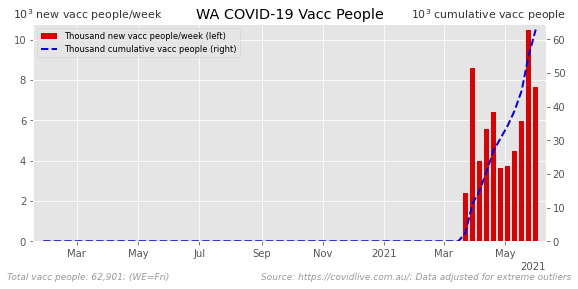

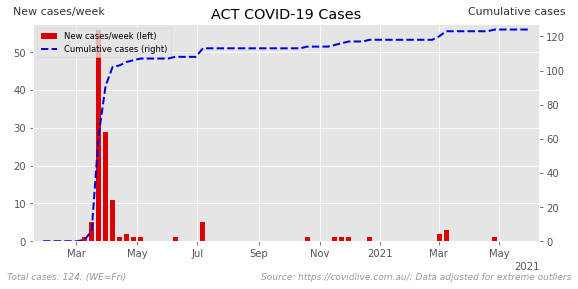

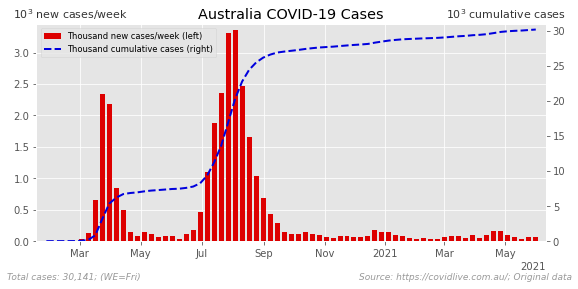

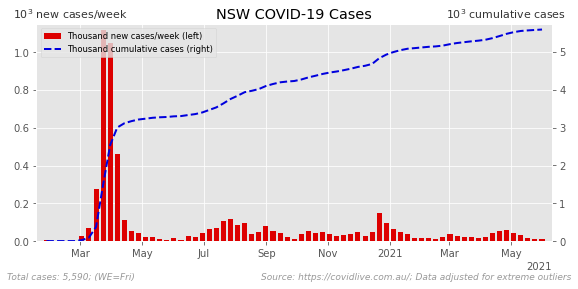

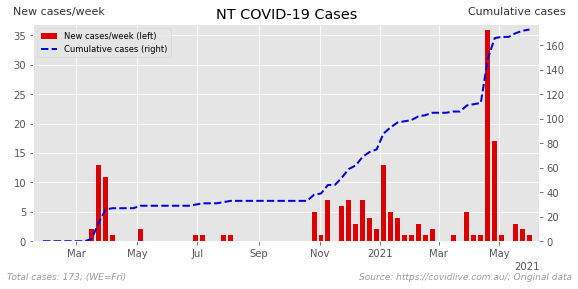

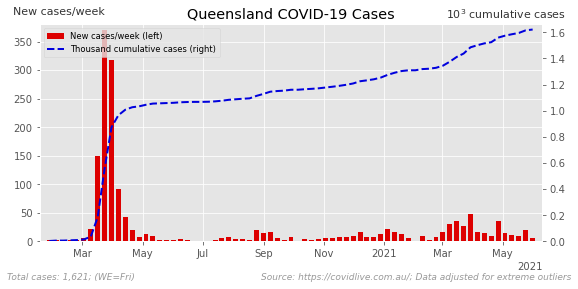

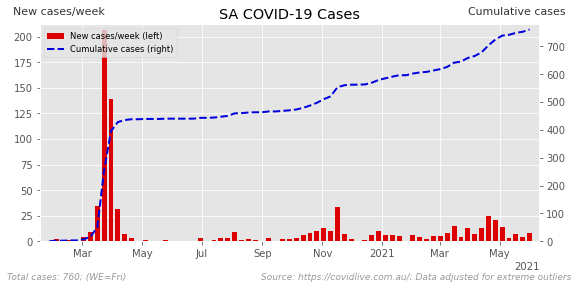

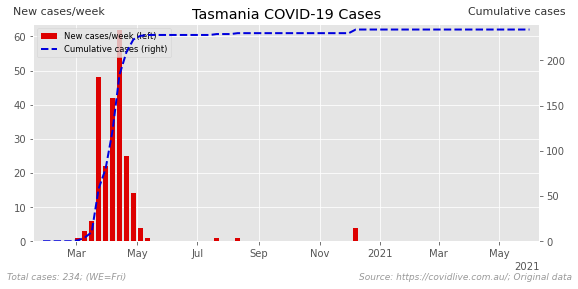

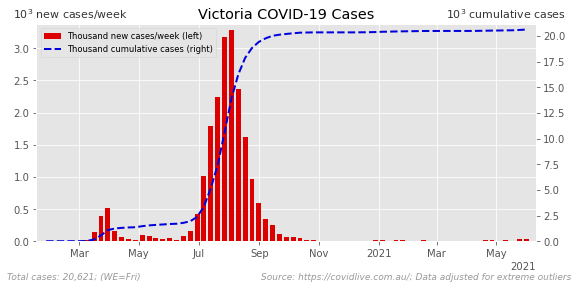

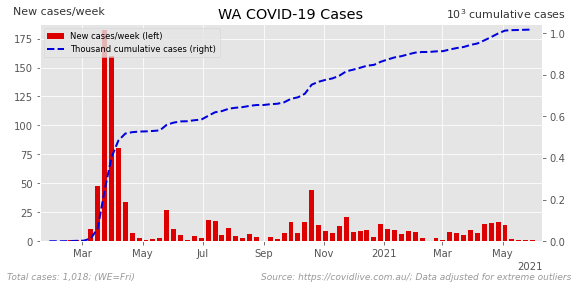

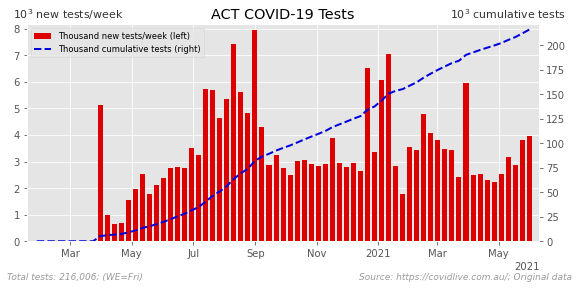

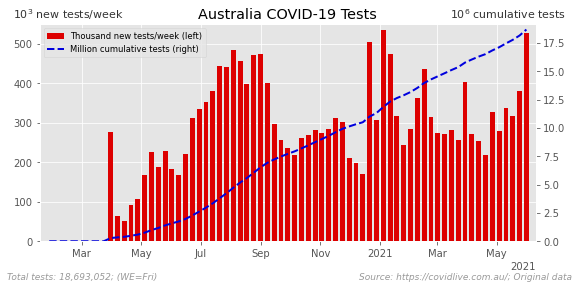

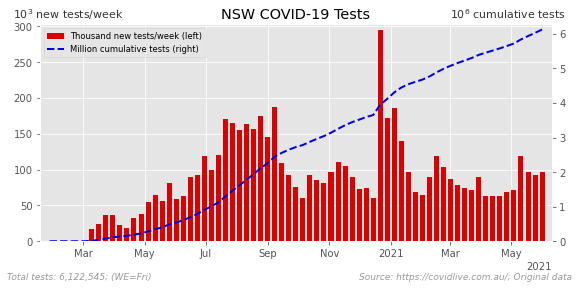

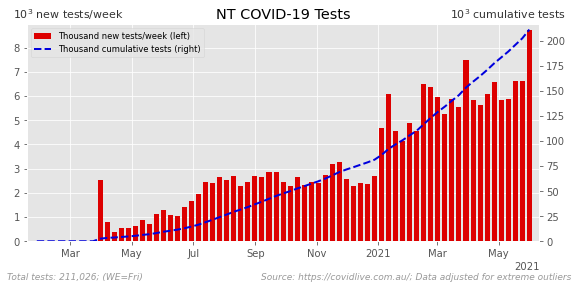

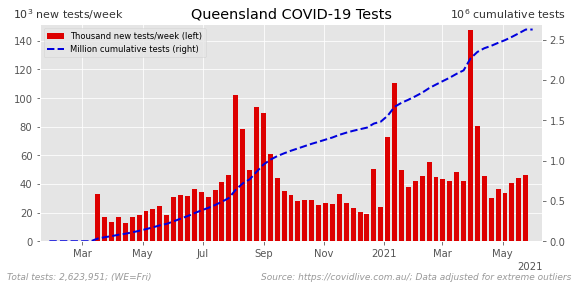

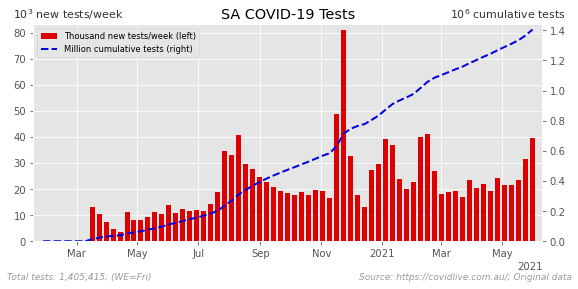

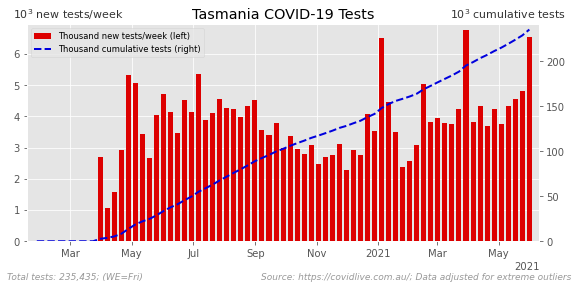

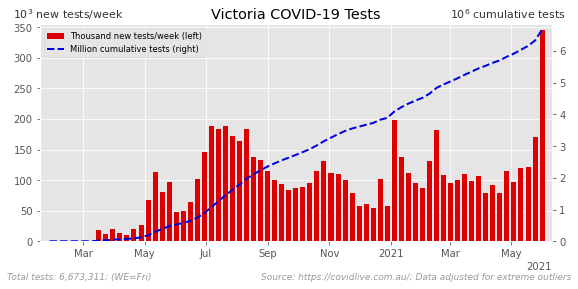

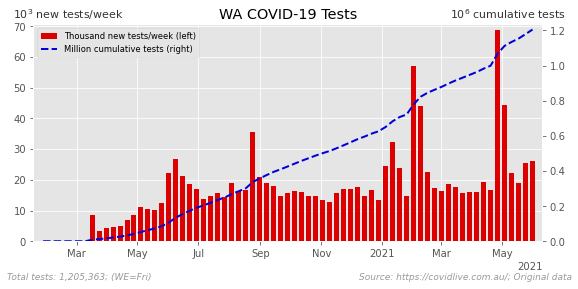

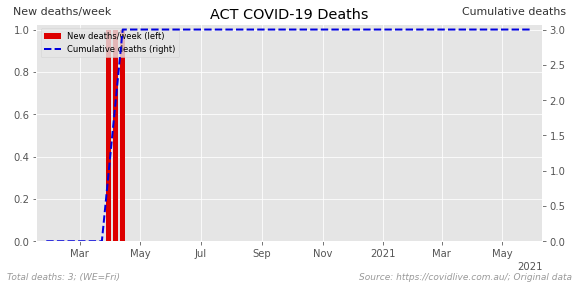

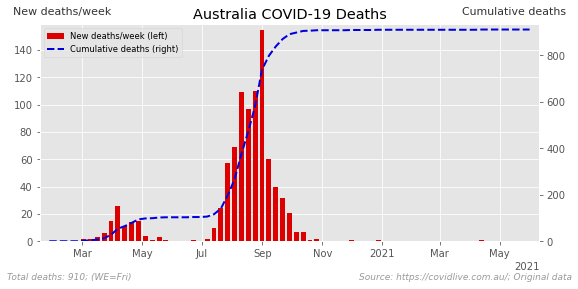

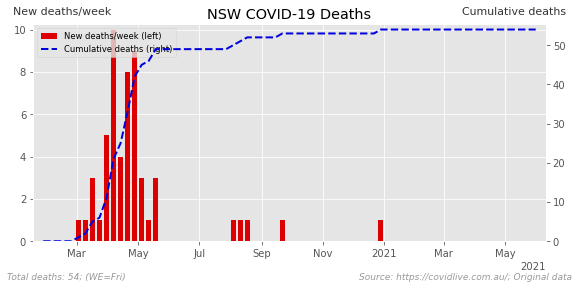

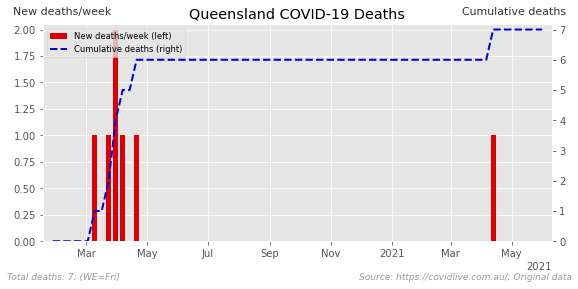

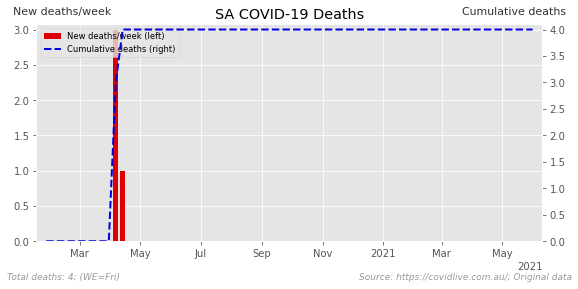

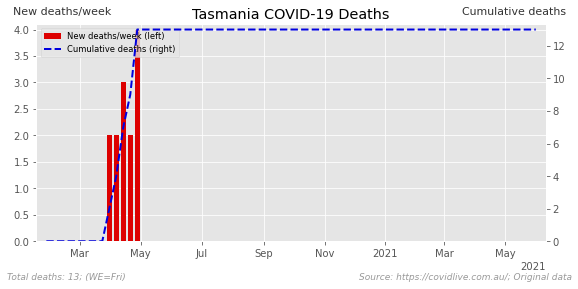

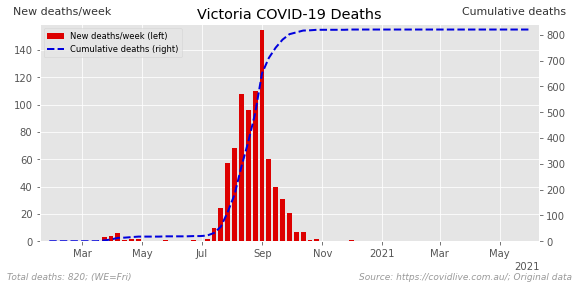

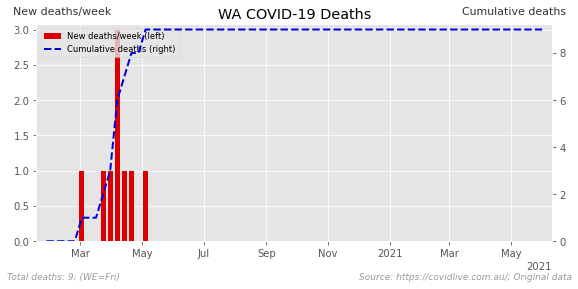

In [8]:
for item, desc in zip(capture_list, capture_desc):
    
    quality = pd.Series(dtype=str)
    for state in daily_u[item].columns:
        if (daily_u[item][state] == daily_c[item][state]).all():
            quality[state] = f'{SOURCE}; Original data'
        else:
            quality[state] = f'{SOURCE}; Data adjusted for extreme outliers'
    
    _ = ps.plot_weekly(
                       daily_c[item], desc, quality, 
                       chart_directory=CHART_DIRECTORY+'-!weekly-',
                       show=True,
                      )

## Bar Charts

In [9]:
def two_bar_plots(data_dict, item, prefix, desc):
    """latest cumulative and cumulative per 
    million population charts"""
    
    last_row = data_dict[item].iloc[-1].sort_values()
    #last_row = last_row[last_row > 0]
    if not len(last_row):
        # no data to plot
        return None
    date = data_dict[item].index[-1].ctime()[:10]
    
    for extra in '', ' per Million Population':
        ps.plot_barh(last_row, 
                     title=f'{prefix} COVID19 {desc}{extra}'.strip(),
                     save_as = f'{CHART_DIRECTORY}!bar-chart-{prefix}-{desc}-{extra}.png',
                     rfooter=SOURCE + ' ' + date,
                     show=True,
                    )
        # per capita second time round ...
        last_row = (last_row / state_pop).round(1).sort_values()

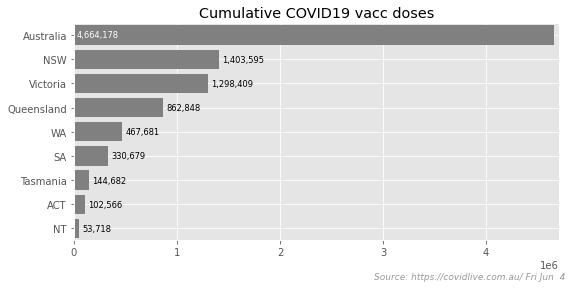

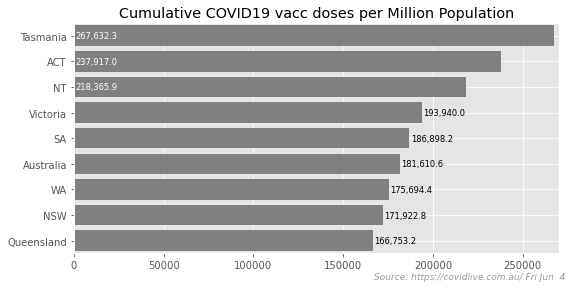

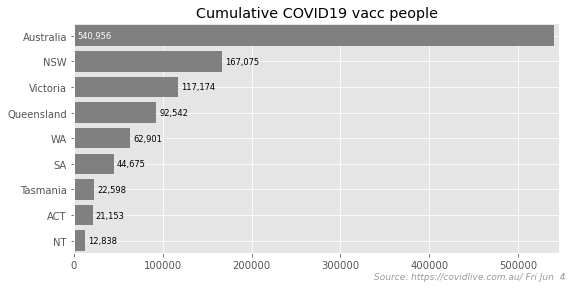

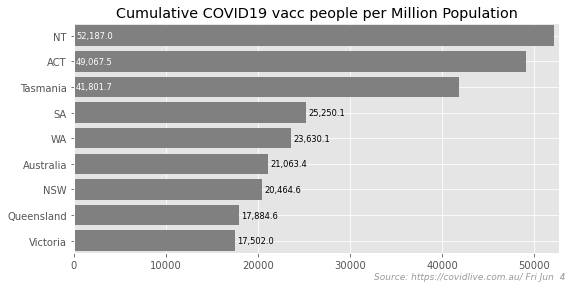

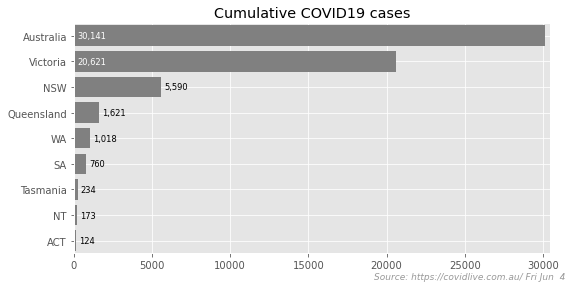

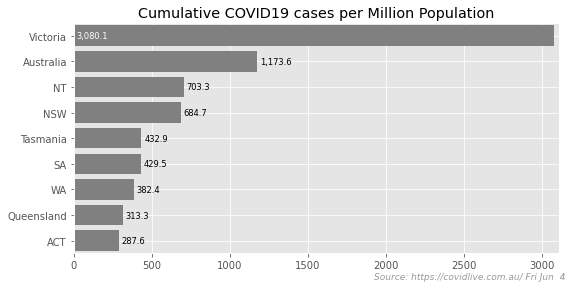

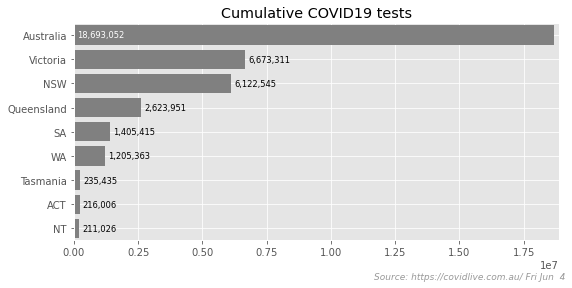

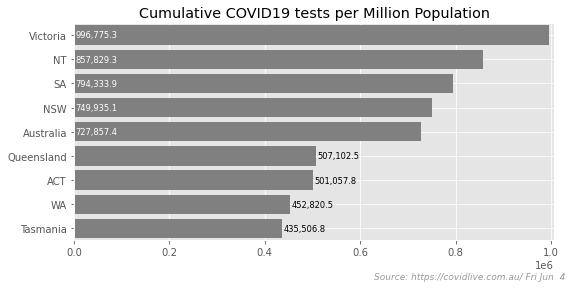

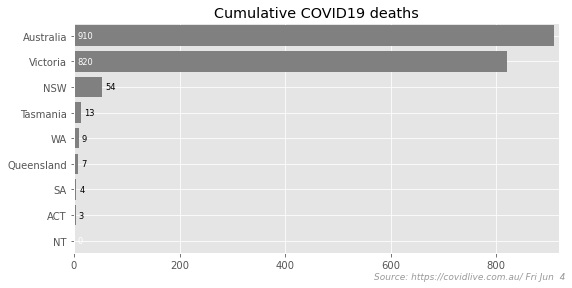

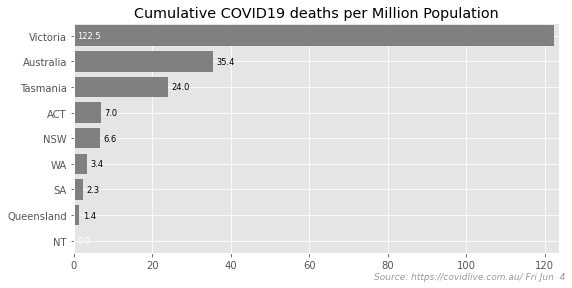

In [10]:
for item, desc in zip(capture_list, capture_desc):
    two_bar_plots(cum_u, item, 'Cumulative', desc)

## Active Cases

In [11]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=AU_COLOURS)

In [12]:
active_all = (
    get_table(frame_data, 'ACTIVE_CNT')
    .dropna(axis=0, how='all')
    .fillna(0)
    .astype(int)
)

### Bar chart of active cases

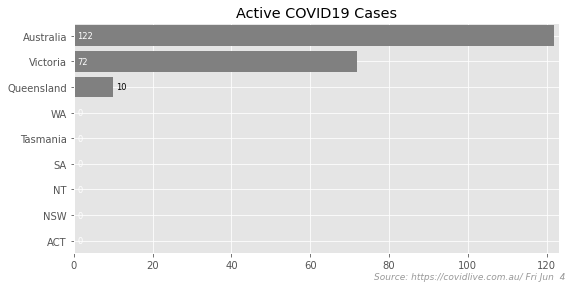

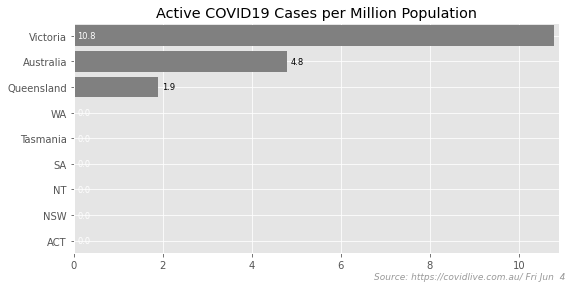

In [13]:
# bar chart of latest active cases
a_dict = {'active': active_all}
two_bar_plots(a_dict, 'active', 'Active', 'Cases')

### Active cases - line plots

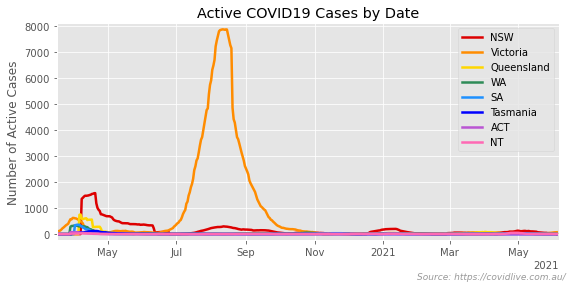

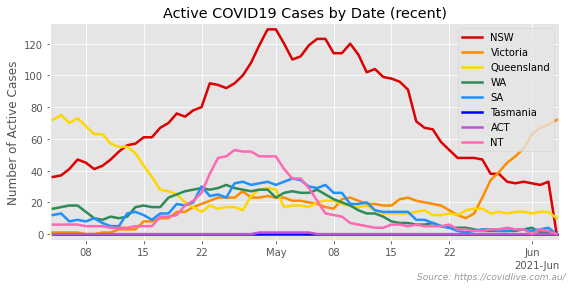

In [14]:
# line plots of trajectories
if 'Australia' in active_all.columns:
    del active_all['Australia']
order = ['NSW', 'Victoria', 'Queensland', 
         'WA', 'SA', 'Tasmania', 'ACT', 'NT']
title = 'Active COVID19 Cases by Date'
MARGINS = (0.005, 0.03)
for recent in [0, RECENT]:
    data = active_all.iloc[-recent:]

    fig, ax = plt.subplots()
    ax.xaxis_date()
    for state in order:
        ax.plot(active_all.index[-recent:].values, 
            active_all[state].iloc[-recent:], 
            label=state, lw=2.5)
    ax.margins(*MARGINS)
    ax.legend(loc='best')
    title_extra = ''
    if recent > 0:
        title_extra = ' (recent)'
    
    ps.finalise_plot(ax, title=title+title_extra, 
                     xlabel=None,
                     chart_directory=CHART_DIRECTORY,
                     ylabel='Number of Active Cases',
                     rfooter=SOURCE,
                     show=True,
                    )

## Source of infection

In [15]:
# build a dictionary of dataframes for infection source data
sources = ['SRC_OVERSEAS_CNT', 
           # 'SRC_SHIP_CNT', # seems to be zero
           'SRC_INTERSTATE_CNT', 'SRC_CONTACT_CNT', 'SRC_UNKNOWN_CNT',
           'SRC_INVES_CNT', 'REPORT_DATE']
names = {
    'SRC_OVERSEAS_CNT': 'Overseas',
    'SRC_INTERSTATE_CNT': 'Interstate',
    'SRC_CONTACT_CNT': 'Known contact',
    'SRC_UNKNOWN_CNT': 'Unknown contact',
    'SRC_INVES_CNT': 'Investigating',
}

state_SOI_data = {}
for state in frame_data.NAME.unique():
    df = frame_data[frame_data.NAME == state][sources].copy()
    df.index = pd.DatetimeIndex(df.REPORT_DATE)
    del df['REPORT_DATE']
    df = df.dropna(axis=0, how='all') # remove empty rows
    if df.iloc[-1].isna().any(): # remove last row if partially complete
        df.drop(df.tail(1).index, inplace=True)
    df = df.rename(columns=names)
    state_SOI_data[state] = df

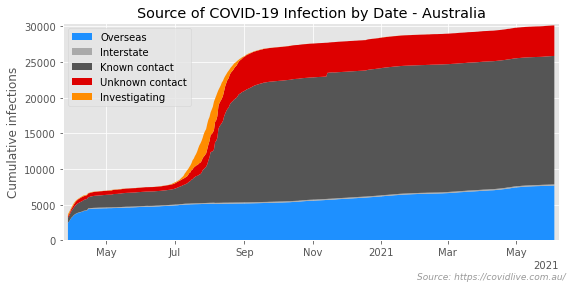

In [16]:
# plot national totals
serious = ['dodgerblue', '#aaaaaa', '#555555', '#dd0000', 'darkorange',]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=serious)
national_soi = state_SOI_data['Australia']
fig, ax = plt.subplots()
ax.stackplot(national_soi.index, 
             national_soi['Overseas'], 
             national_soi['Interstate'], 
             national_soi['Known contact'], 
             national_soi['Unknown contact'], 
             national_soi['Investigating'], 
             labels = ['Overseas', 'Interstate', 'Known contact', 
                       'Unknown contact', 'Investigating'])
ax.legend(loc='upper left')
ax.margins(0.01)

title = 'Source of COVID-19 Infection by Date - Australia'
ps.finalise_plot(ax, title=title, 
                 chart_directory=CHART_DIRECTORY,
                 xlabel=None, ylabel='Cumulative infections',
                 rfooter=SOURCE,
                 show=True,
                )

In [17]:
# extract the latest data, and under investigation
states = list(frame_data.NAME.unique())
states.remove('Australia')
latest = pd.DataFrame()
investigating = pd.DataFrame()
for state in states:
    df = state_SOI_data[state].sort_index()
    df = df.dropna(axis=0, how='all')
    investigating[state] = df['Investigating']
    latest[state] = df.iloc[-1]
    if latest[state].isna().any():
        print(f'Warning: data not current for {state}')
        print(latest[state][latest[state].isna()])
        warning_count += 1
        latest[state] = df.iloc[-2]
        
latest

,NSW,Victoria,Queensland,WA,SA,Tasmania,ACT,NT
Overseas,3404.0,1144.0,1293.0,910.0,573.0,85.0,95.0,169.0
Interstate,90.0,0.0,23.0,7.0,26.0,3.0,8.0,2.0
Known contact,1645.0,15709.0,264.0,87.0,152.0,141.0,20.0,2.0
Unknown contact,451.0,3764.0,41.0,14.0,9.0,5.0,1.0,0.0
Investigating,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


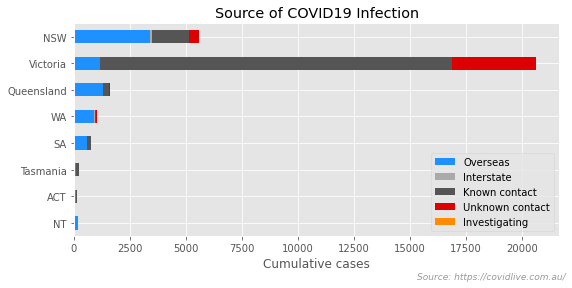

In [18]:
# plot the latest data
serious = ['dodgerblue', '#aaaaaa', '#555555', '#dd0000', 'darkorange',]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=serious)
ax = latest.T[::-1].plot.barh(stacked=True)
title = 'Source of COVID19 Infection'
ps.finalise_plot(ax, title=title, 
                 chart_directory=CHART_DIRECTORY,
                 xlabel='Cumulative cases', ylabel=None,
                 rfooter=SOURCE,
                 show=True,
                )

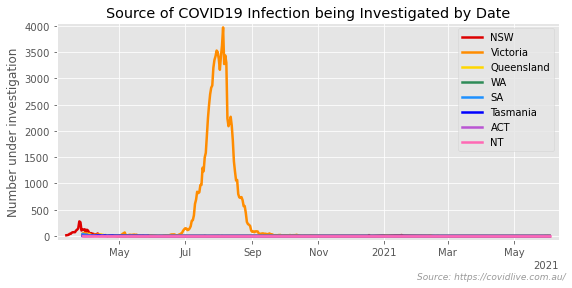

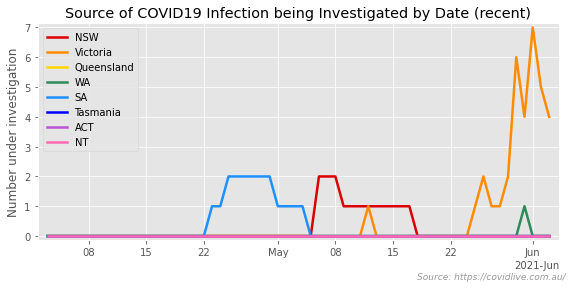

In [19]:
# plot under investigation
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=AU_COLOURS)
for recent in [0, RECENT]:
    fig, ax = plt.subplots()
    ax.margins(0.02)
    for state in investigating.columns:
        ax.plot(investigating.index[-recent:],
                investigating[state].iloc[-recent:],
                lw=2.5, label=state)
    ax.legend(loc='best')
    title = 'Source of COVID19 Infection being Investigated by Date'
    plus = ''
    if recent > 0:
        plus = ' (recent)'

    ps.finalise_plot(ax, 
                     title=title+plus, 
                     chart_directory=CHART_DIRECTORY,
                     xlabel=None, ylabel='Number under investigation',
                     rfooter=SOURCE,
                     show=True,
                    )

## Local cases - speculative 
Note: calculated using the source of infection data

### Create dataframe of local tranmission

In [20]:
# definition of local (Australian) transmission
local_trans = ['Interstate', 'Known contact', 'Unknown contact', 'Investigating',]
local = 'LOCAL_TRANS'

# calculate from from Sourse of Infection data collected above
local_trans_df = pd.DataFrame()
for state in state_SOI_data:
    local_trans_df[state] = state_SOI_data[state][local_trans].sum(axis=1)
cum_u[local] = (
    local_trans_df
    .sort_index(ascending=True)
    .replace({0: np.nan})
    .ffill()
    .fillna(0)
    .astype(int)
)

# usual corrections
daily_u[local], daily_c[local], cum_c[local] = (
    ps.dataframe_correction(cum_u[local], verbose=False)
)

### Bar charts cumulative local transmission

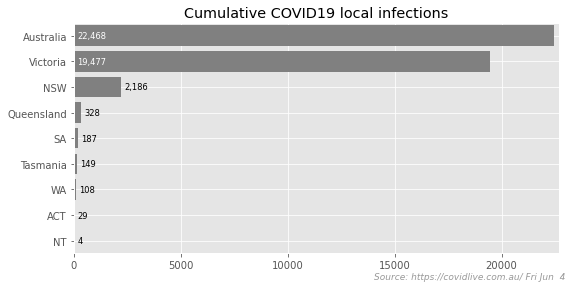

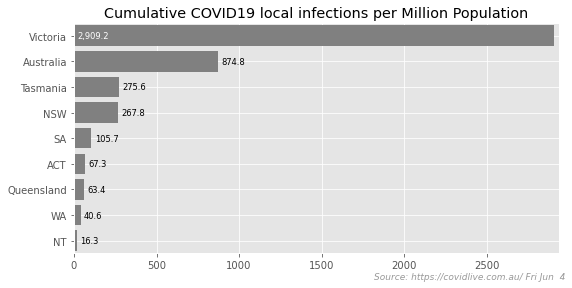

In [21]:
two_bar_plots(cum_u, local, 'Cumulative', 'local infections')

### Weekly charts for local transmission

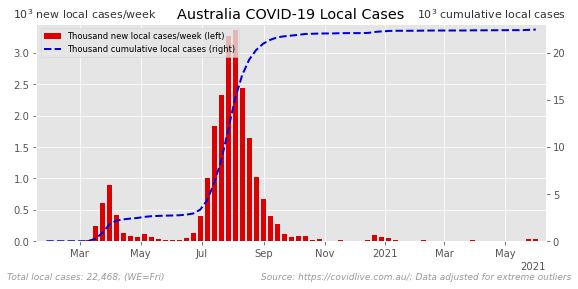

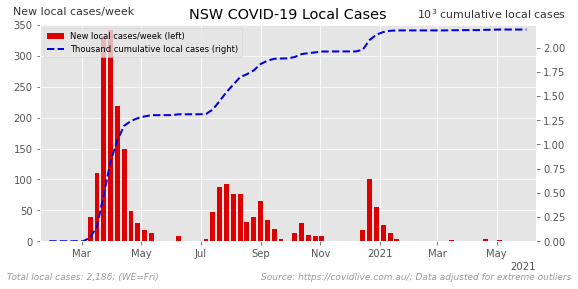

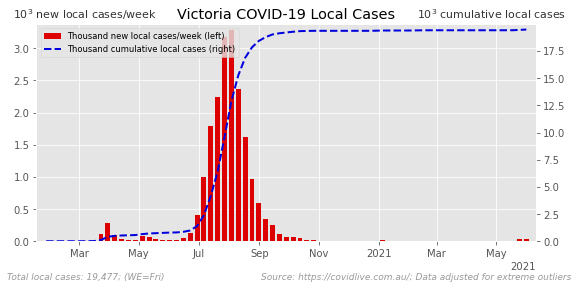

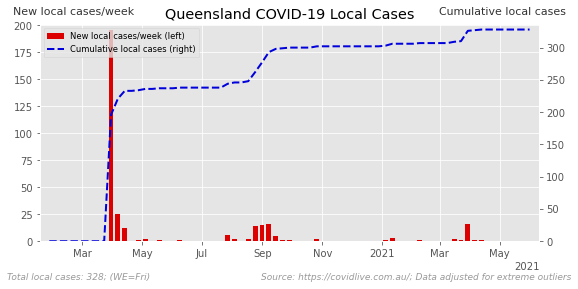

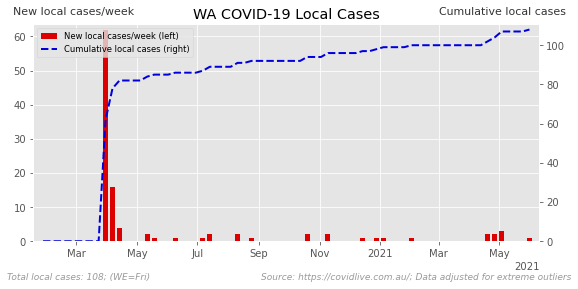

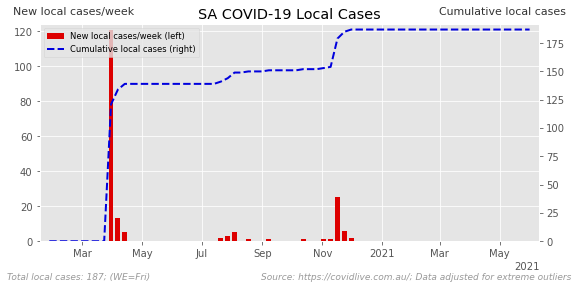

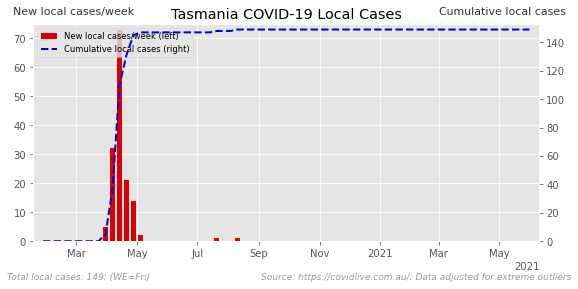

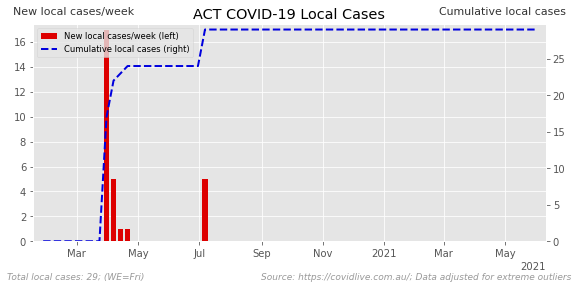

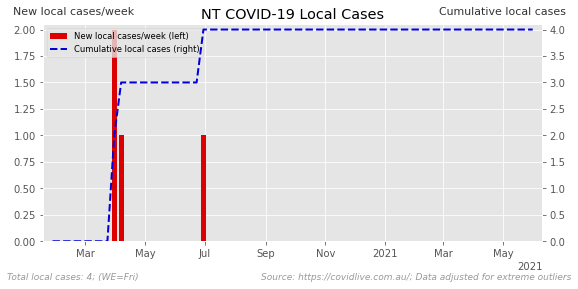

In [22]:
quality = pd.Series(dtype=str)
for state in daily_u[local].columns:
    if (daily_u[local][state] == daily_c[local][state]).all():
        quality[state] = f'{SOURCE}; Original data'
    else:
        quality[state] = f'{SOURCE}; Data adjusted for extreme outliers'

desc = 'local cases'
_ = ps.plot_weekly(
    daily_c[local], desc, quality, 
    chart_directory=f'{CHART_DIRECTORY}-!{desc}-',
    show=True,
)

### Recent local transmission daily charts

In [23]:
local_lfooter = f'Local = {" + ".join(local_trans)}'

def recent_bar_with_ma_plot(df, mode):
    """plotting function - bar charts for daily local transmission,
       with 7 and 14 day moving averages."""
    
    # establish moving average periods
    MA1 = 7 # days
    MA2 = 14 # dats
    
    for col in df.columns:
        series = df[col]
        
        # bail if nothing to plot
        if series[-RECENT:].sum() <= 0: 
            continue
            
        # get plotables for recent period
        ma1 = series.rolling(MA1).mean()[-RECENT:]
        ma2 = series.rolling(MA2).mean()[-RECENT:]
        series = series[-RECENT:]
        
        # plot
        MARGINS = 0.015
        fig, ax = plt.subplots()
        ax.xaxis_date()
        ax.margins(MARGINS) # seems to work here
        ax.bar(series.index, series, label=mode, 
               color='#dd0000')
        ax.plot(ma1.index, ma1, label=f'{MA1} day ave.', 
                color='darkorange')
        ax.plot(ma2.index, ma2, label=f'{MA2} day ave.', 
                color='cornflowerblue')
        
        # annotate / finalise plot
        ax.legend(loc='best')
        title = (f'New Locally Acquired COVID19 {mode.title()} '
                 f'in {col} - Recent')
        ps.finalise_plot(ax, 
                         title=title, 
                         chart_directory=f"{CHART_DIRECTORY}-recent-local-",
                         xlabel=None,
                         ylabel=f'Daily New {mode.title()}',
                         lfooter=local_lfooter,
                         rfooter=SOURCE,
                         show=True,
                        )

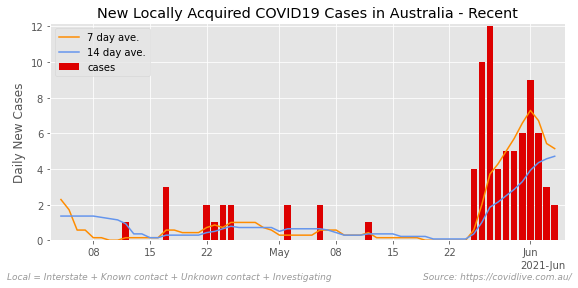

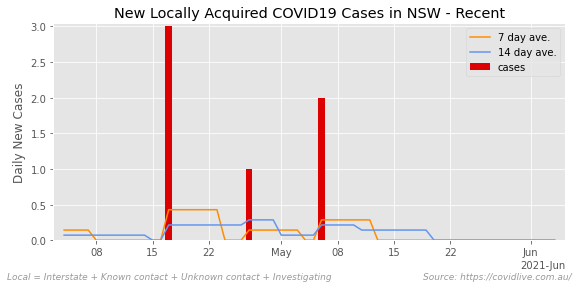

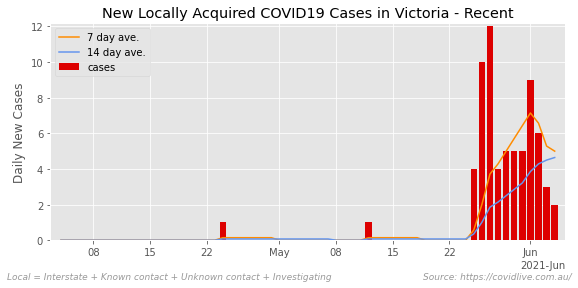

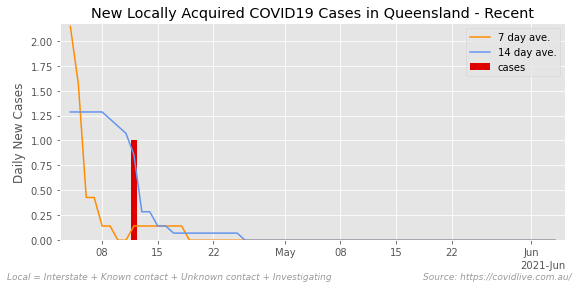

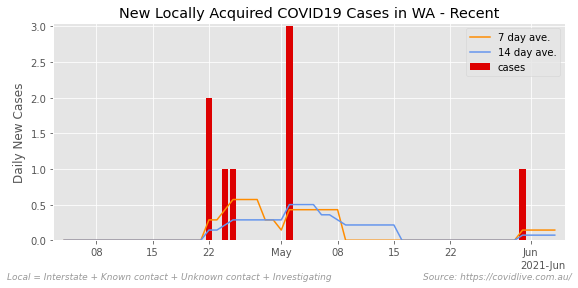

In [24]:
# and plot it
recent_bar_with_ma_plot(daily_c[local], "cases")

### Compare Sydney and Melbourne outbreaks

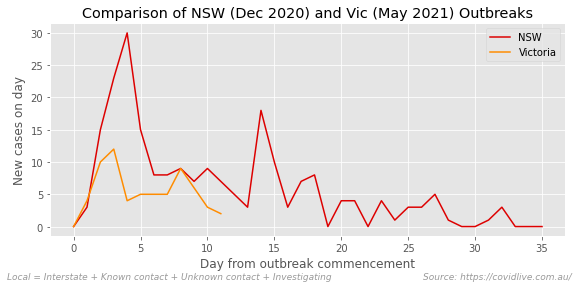

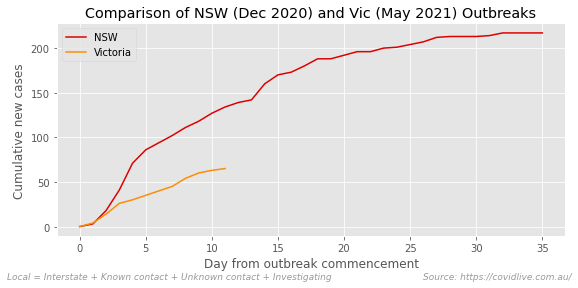

In [28]:
def select(state, start_date, span=36):
    local = 'LOCAL_TRANS'
    series = daily_c[local][state]
    return (
        series[series.index >= pd.Timestamp(start_date)]
        .iloc[:span]
        .reset_index(drop=True)
    )

nsw = select('NSW', '2020-12-16')
vic = select('Victoria', '2021-05-24')
comparable = pd.DataFrame([nsw, vic]).T

y1 = 'New cases on day'
d1 = comparable
y2 = 'Cumulative new cases'
d2 = comparable.cumsum()
for ylabel, data in zip((y1, y2), (d1, d2)):
    ax = data.plot()
    title = f'Comparison of NSW (Dec 2020) and Vic (May 2021) Outbreaks'
    ps.finalise_plot(ax,
                 title=title, 
                 chart_directory=f"{CHART_DIRECTORY}",
                 ylabel=ylabel,
                 xlabel=f'Day from outbreak commencement',
                 save_tag=ylabel.split()[0],
                 lfooter=local_lfooter,
                 rfooter=SOURCE,
                 show=True,
    )

## Hospitalised

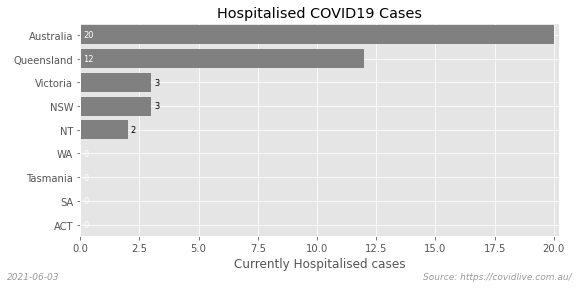

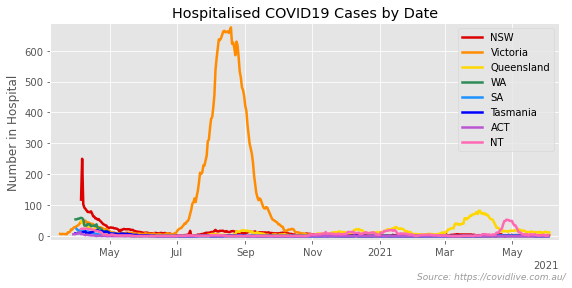

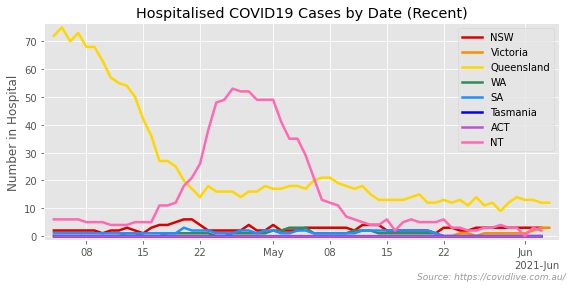

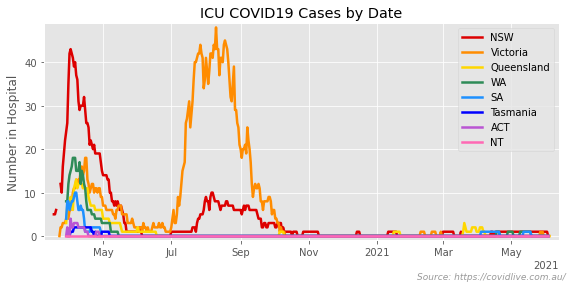

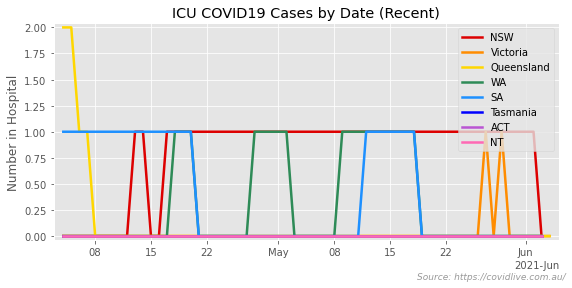

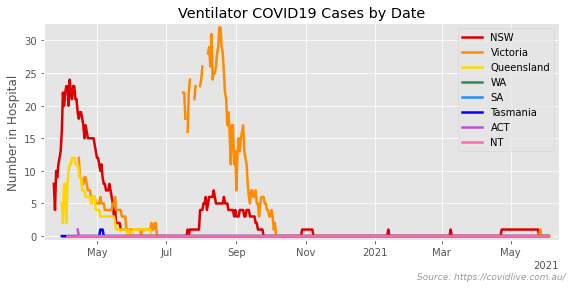

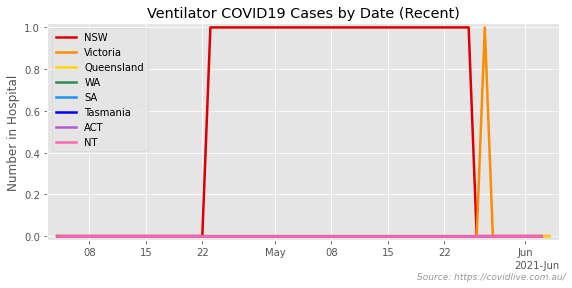

In [26]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=AU_COLOURS)
idents = ['MED_HOSP_CNT', 'MED_ICU_CNT', 'MED_VENT_CNT']
descs = ['Hospitalised', 'ICU', 'Ventilator']

for ident, desc in zip(idents, descs):

    hospital = frame_data.pivot(index='REPORT_DATE', columns='NAME', values=ident)
    hospital.index = pd.DatetimeIndex(hospital.index)
    hospital = hospital.dropna(axis=0, how='all')

    # bar chart of latest data
    latest = hospital.copy()
    if latest.iloc[-1].isna().any():
        latest.drop(latest.index[-1], inplace=True)
    row = latest.iloc[-1].astype(int)
    if row.sum() > 0:
        lfooter = str(row.name.date())
        title = f'{desc} COVID19 Cases'
        ps.plot_barh(row.sort_values(ascending=True), 
                     title=title,
                     xlabel=f'Currently {desc} cases',
                     save_as = f'{CHART_DIRECTORY}{title}.png',
                     rfooter=SOURCE,
                     lfooter=lfooter,
                     show=True,
                    )
    
    # plot hospitalised as a line chart
    for start in [0, -RECENT]:
        dataset = hospital.iloc[start:]
        if dataset.sum().sum() == 0:
            continue
        fig, ax = plt.subplots()
        ax.xaxis_date()
        ax.margins(0.02)
        for state in order:
            ax.plot(dataset.index, 
                    dataset[state], 
                    label=state, lw=2.5)
        ax.legend(loc='best')

        title = f'{desc} COVID19 Cases by Date'
        if start == -RECENT:
            title += ' (Recent)'
        ps.finalise_plot(ax, 
                         title=title, 
                         chart_directory=CHART_DIRECTORY,
                         xlabel=None,
                         ylabel='Number in Hospital',
                         rfooter=SOURCE,
                         show=True,
                        )

## The End

In [27]:
print('Finished')

if warning_count:
    print(f'Check {warning_count} '
          f'warning{"s" if warning_count > 1 else ""} above')

Finished
